# Bài thực hành nhóm Tuần 6 - Nhập môn Máy học - Support Vector Machine

**Thông tin nhóm:**
- Trần Tuấn Thái - MSSV: 20280082
- Huỳnh Quang Trung - MSSV: 20280108
- Lớp: 20TH_KHDL

**Bài làm được thực hiện trên Google Colab**

---

**Requirements:**
- Apply all knowledge and techniques that you have learned for this
- You must organize your notebook based on the Homework
- Should not drop NA and missing value

**Deadline:**
- 3 weeks - (2023-06-25)


## Import Module



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from datetime import datetime
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.svm import SVC

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Load dataset

In [ ]:
PATH = "/content/drive/MyDrive/Final NMMH/churn_rate_prediction.csv"
data = pd.read_csv(PATH)

In [ ]:
data.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


## Data Analysis & Preprocessing

Tạo một dataframe sao chép của dữ liệu gốc để vừa phân tích vừa xử lý mà không là ảnh hưởng đến bộ data gốc.

In [ ]:
df = data.copy()

In [ ]:
print(f'Tập dữ liệu có {df.shape[0]} dòng và {df.shape[1]} cột')

Tập dữ liệu có 36992 dòng và 25 cột


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

Nhận xét:
- Các cột có chứa giá trị null: `region_category`, `preferred_offer_types`, `points_in_wallet`
- Các cột còn lại đều không chứa giá trị các giá trị bị thiếu.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36992.0,37.118161,15.867412,10.000000,23.0000,37.000,51.000,64.000000
days_since_last_login,36992.0,-41.915576,228.819900,-999.000000,8.0000,12.000,16.000,26.000000
avg_time_spent,36992.0,243.472334,398.289149,-2814.109110,60.1025,161.765,356.515,3235.578521
avg_transaction_value,36992.0,29271.194003,19444.806226,800.460000,14177.5400,27554.485,40855.110,99914.050000
points_in_wallet,33549.0,686.882199,194.063624,-760.661236,616.1500,697.620,763.950,2069.069761
churn_risk_score,36992.0,3.463397,1.409661,-1.000000,3.0000,4.000,5.000,5.000000


Dựa và phần thống kê mô tả phía trên, ta có nhận xét như sau:
- Cột `days_since_last_login` là cột chứa thông tin số ngày kể từ lần cuối khách hàng đăng nhập trang web nhưng lại có min = -999 và mean = -41.915576 => Chứa các giá trị sai.
- Tương tự, cột `avg_time_spent`, `point_in_wallet` và `churn_risk_score` là các cột chứa thông tin về thời gian, tiền tệ và mức độ rời bỏ dịch vụ nhưng cũng chứa các giá trị âm không đúng.

Ta kiểm tra xem trong tập dữ liệu có các giá trị NaN nào hay không

In [ ]:
df.isna().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

Có 3 cột chứa các giá trị khuyết:
- `region_category`
- `preferred_offer_types`
- `points_in_wallet`

Ta thực hiện viết một hàm trả về các giá trị unique có trong mỗi cột:

In [ ]:
# Hàm trả về các giá trị unique trong từng cột của dataframe
def unique_values(dataframe):
    unique_vals = {}
    for col in dataframe.columns:
        col_sorted = pd.Series(dataframe[col]).sort_values().unique()
        unique_vals[col] = col_sorted
    return unique_vals

In [ ]:
unique = unique_values(df)
for key, value in unique.items():
    print(f'Column {key}: {value}')
    print()

Column customer_id: ['fffe4300490044003100' 'fffe43004900440031003000'
 'fffe4300490044003100300030003000' ... 'fffe4300490044003900390039003700'
 'fffe4300490044003900390039003800' 'fffe4300490044003900390039003900']

Column Name: ['Aaron Achenbach' 'Aaron Bay' 'Aaron Berman' ... 'Zoraida Wheeless'
 'Zoraida Williamson' 'Zoraida Zerby']

Column age: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64]

Column gender: ['F' 'M' 'Unknown']

Column security_no: ['000NYHU' '002F9PP' '0038JWG' ... 'ZZYRKKX' 'ZZYZ9JZ' 'ZZZAP21']

Column region_category: ['City' 'Town' 'Village' nan]

Column membership_category: ['Basic Membership' 'Gold Membership' 'No Membership'
 'Platinum Membership' 'Premium Membership' 'Silver Membership']

Column joining_date: ['2015-01-01' '2015-01-02' '2015-01-03' ... '2017-12-29' '2017-12-30'
 '2017-12-31']

Column joined_through_referral: ['?' 'No' 'Y

Ta quan sát được ở tập dữ liệu có xuất hiện các cột liên quan về thông tin riêng tư của khách hàng như: `customer_id`, `Name`, `security_no`, `referral_id`, ta cũng quyết định sẽ xóa các cột này ra khỏi tập dữ liệu.

In [ ]:
df = df.drop(['customer_id', 'Name', 'security_no', 'referral_id'], axis=1)

Ta thấy ở một số cột có mang các giá trị dữ liệu đặc biệt, cụ thể:
- Cột `region_category`, `preferred_offer_types` và `points_in_wallet` có chứa giá trị NaN
- Cột `medium_of_operation` và `joined_through_referral` có chứa ký tự "?"
- Cột `days_since_last_login`, `points_in_wallet`, `avg_frequency_login_days` và `avg_time_spent` thể hiện thông tin phải mang giá trị >= 0 nhưng lại đang chứa các giá trị âm.
- Cột `avg_frequency_login_days` là cột numerical nhưng lại đang mang kiểu dữ liệu là string (object)
- Cột `avg_frequency_login_days` chứa giá trị 'Error'
- Cột `churn_risk_score` chứa giá trị -1, trong khi theo như mô tả thì cột này chỉ chứa các giá trị từ 1 đến 5.
- Ngoài ra, cột `gender` còn có giá trị 'Unknown'

=> Sẽ có một step để xử lý các trường hợp này, đó là: Ta sẽ tạm thay thế các giá trị không đúng ở các feature thành các NaN sau đó sẽ dùng một phương pháp khác để dự đoán và điền vào các giá trị NaN này.

Tiếp theo, ta sẽ có một bước vẽ đồ thị boxplot của các feature dạng numerical, nhưng trước tiên hãy xử lý cột numerical mà đang ở dạng object vì chứa giá trị chuỗi 'Error', đó chính là cột `avg_frequency_login_days`. Ta sẽ thay thế giá trị 'Error' này thành NaN, sau đó sẽ chuyển cột này sang kiểu dữ liệu float:

In [ ]:
def processing_error_value(df):
  for col in df.columns:
    df[col] = df[col].replace('Error', np.NaN)

In [ ]:
processing_error_value(df)
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype('float64')

Tiếp theo, như đã phân tích ở trên thì các cột khác cũng đang mang giá trị số âm, giá trị '?' và 'Unknown'. Do đó, ta cũng sẽ thay thế các giá trị không đúng này thành NaN.

In [ ]:
# Hàm thay thế unknown thành np.NaN
def processing_unknown_value(df):
  for col in df.columns:
    df[col] = df[col].replace('Unknown', np.NaN)

In [ ]:
# Hàm thay thế '?''thành np.NaN
def replace_question_mark(df):
  for col in df.columns:
    df[col] = df[col].replace('?', np.NaN)

Tiếp theo, ta sẽ viết một hàm có chức năng thay thế các giá trị âm ở các cột thành np.NaN

In [ ]:
def replace_negative_values_with_nan(df, columns):
    # Lặp qua từng cột trong DataFrame
    for column in columns:
        # Thay thế các giá trị âm bằng np.NaN
        df[column] = np.where(df[column] < 0, np.NaN, df[column])

In [ ]:
processing_unknown_value(df) # gọi hàm thay thế 'Unknown' thành NaN.
replace_question_mark(df) # gọi hàm thay thế '?' thành NaN

negative_col = ['days_since_last_login', 'points_in_wallet', 'avg_frequency_login_days', 'avg_time_spent', 'churn_risk_score'] # Các cột chứa số âm
replace_negative_values_with_nan(df, negative_col) # Thay thế các giá trị âm trong các cột này thành NaN

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36992.0,37.118161,15.867412,10.000000,23.00,37.000,51.00,64.000000
days_since_last_login,34993.0,12.758552,5.572600,1.000000,9.00,13.000,17.00,26.000000
avg_time_spent,35273.0,292.751466,331.946382,1.837399,71.56,174.180,371.16,3235.578521
avg_transaction_value,36992.0,29271.194003,19444.806226,800.460000,14177.54,27554.485,40855.11,99914.050000
avg_frequency_login_days,32787.0,16.538615,8.383666,0.009208,10.00,16.000,23.00,73.061995
points_in_wallet,33413.0,690.354685,186.426973,6.432208,617.26,698.250,764.26,2069.069761
churn_risk_score,35829.0,3.608278,1.176426,1.000000,3.00,4.000,5.00,5.000000


In [ ]:
df.isna().sum()

age                                0
gender                            59
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral         5438
preferred_offer_types            288
medium_of_operation             5393
internet_option                    0
last_visit_time                    0
days_since_last_login           1999
avg_time_spent                  1719
avg_transaction_value              0
avg_frequency_login_days        4205
points_in_wallet                3579
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                1163
dtype: int64

Tiếp theo, ta lấy ra tên các cột có dạng numerical và categorical:

In [ ]:
# Lấy tên các cột numerical
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove('churn_risk_score') # Ta phải bỏ cột này ra bởi vì đây là cột phân loại rời rạc các mức độ từ 1 đến 5.

# Lấy tên các cột categorical
categorical_columns = df.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
categorical_columns.append('churn_risk_score') # Thêm cột churn_risk_score vào danh sách các cột categorical

Viết hàm xem qua boxplot của các cột numerical:

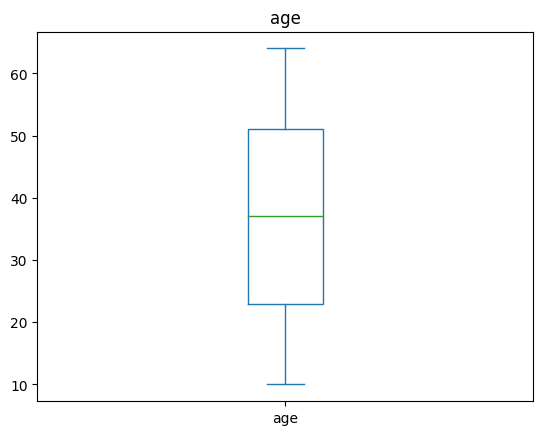

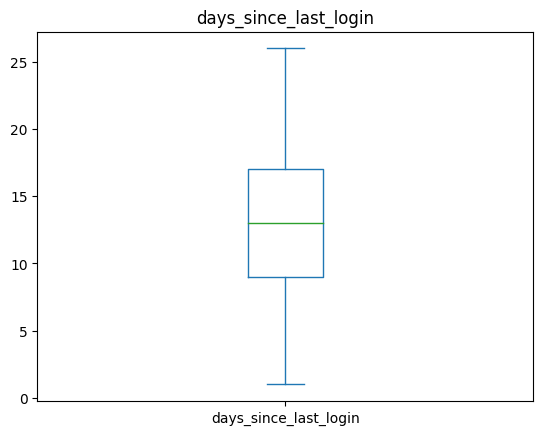

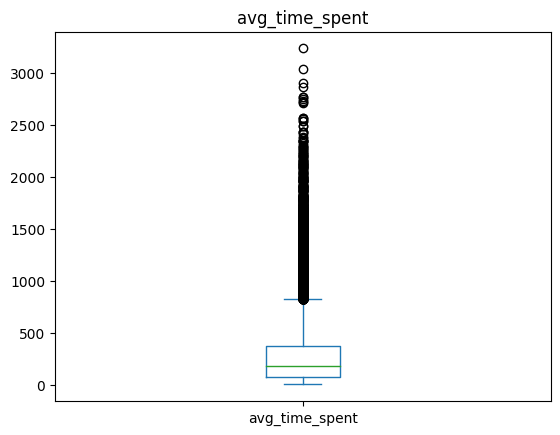

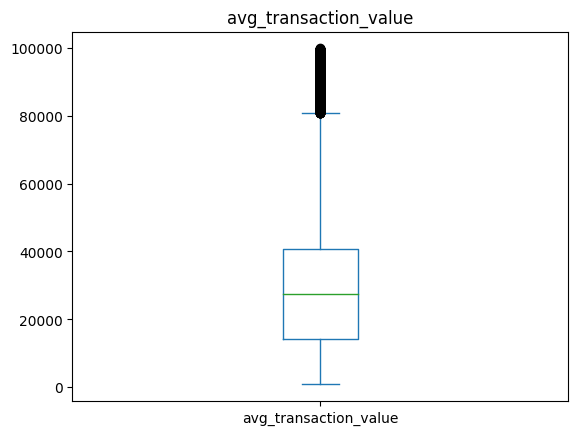

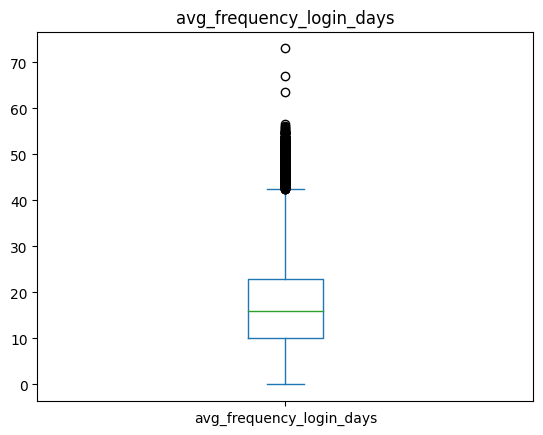

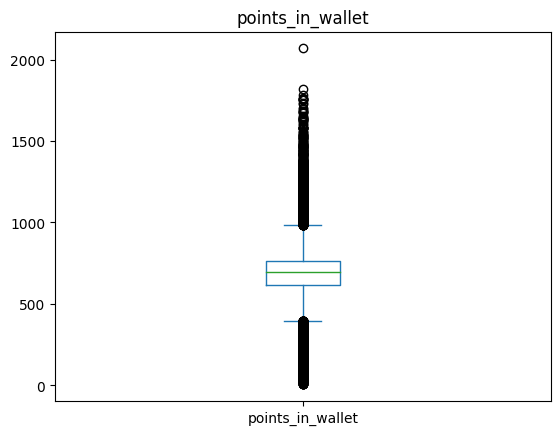

In [ ]:
def draw_boxplot(dataframe, column_names):
    for column in column_names:
        plt.figure()
        dataframe[column].plot(kind='box')
        plt.title(column)
        plt.show()

draw_boxplot(df, numeric_columns)

Các cột numerical này có rất nhiều các giá trị outlier cần xử lý vì thế ta cũng sẽ quyết định thay thế hết các giá trị outlier này thành NaN để chờ cho bước xử lý tiếp theo. Ta sẽ thay thế các giá trị nằm ngoài khoảng giá trị [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] thành NaN:

In [ ]:
def replace_outliers(df, columns):
    for col in columns:
        # Tính phạm vi IQR
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # Xác định giá trị ngoài cận
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Thay thế giá trị ngoài cận bằng np.NaN
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), np.NaN, df[col])

replace_outliers(df, numeric_columns)

Sau khi thay các giá trị bị sai lệch và các giá trị outlier, ta xem lại số các giá trị NaN trong tập dữ liệu:

In [ ]:
df.isnull().sum()

age                                0
gender                            59
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral         5438
preferred_offer_types            288
medium_of_operation             5393
internet_option                    0
last_visit_time                    0
days_since_last_login           1999
avg_time_spent                  4700
avg_transaction_value           1131
avg_frequency_login_days        4539
points_in_wallet                7825
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                1163
dtype: int64

Có rất nhiều giá trị NaN mà chúng ta cần phải fill. Ở đây chúng ta sẽ xử lý các giá trị NaN này theo 2 trường hợp:
- Đối với các cột là categorical: Ta sẽ fill các NaN ở những cột này bằng giá trị mode (giá trị xuất hiện nhiều nhất trong cột)
- Đối với các cột dạng numerical, ta sẽ sử dụng KNNImputer của thư viện scikit-learn để dự đoán các missing values và fill vào các NaN này.

In [ ]:
# Hàm fill NaN cho các cột numerrical
def fillna_numerical(df, numerical_columns):
    # Tạo DataFrame tạm thời chỉ chứa các cột numerical
    df_numerical = df[numerical_columns]

    # Khởi tạo KNNImputer
    imputer = KNNImputer(n_neighbors=15) # Sử dụng 15 láng giềng gần nhất để ước lượng mising value

    # Fill giá trị NaN trong DataFrame tạm thời
    df_filled = pd.DataFrame(imputer.fit_transform(df_numerical), columns=numerical_columns)

    # Gán lại các cột đã fill vào DataFrame gốc
    df[numerical_columns] = df_filled

# Gọi hàm
fillna_numerical(df, numeric_columns)

Viết hàm fill các giá trị NaN trong các cột dạng categorical bằng giá trị mode của cột đó.

In [ ]:
# Hàm fill NaN cho các cột categorical
def fillna_categorical_mode(df, categorical_columns):
    # Lặp qua từng cột dạng categorical
    for column in categorical_columns:
        # Lấy giá trị mode của cột
        mode_value = df[column].mode().iloc[0]
        # Fill giá trị NaN bằng mode
        df[column].fillna(mode_value, inplace=True)

# Gọi hàm
fillna_categorical_mode(df, categorical_columns)

In [ ]:
df.isna().sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joining_date                    0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
last_visit_time                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
churn_risk_score                0
dtype: int64

Như vậy là ta đã xử lý xong phần các giá trị bị sai, outlier cũng như các NaN trong tập dữ liệu. Tiếp theo, ta để ý thấy 2 cột `joining_date` và `last_visit_time` là 2 cột dạng ngày tháng, nhưng đang không ở trong kiểu dữ liệu chính xác của nó (datetime). Vì vậy, tiếp theo ta sẽ chuyển kiểu dữ liệu của 2 cột này sang kiểu dữ liệu datetime để dễ dàng xử lý sau này.

In [ ]:
# Chuyển dữ liệu cột 'joining_date' sang kiểu datetime
df['joining_date'] = pd.to_datetime(df['joining_date'], format='%Y-%m-%d')

# Chuyển dữ liệu cột 'last_visit_time' sang kiểu time
df['last_visit_time'] = df['last_visit_time'].apply(lambda x: datetime.strptime(x, "%H:%M:%S").time())

Như vậy là ta đã hoàn thành xong step phân tích và tiền xử lý dữ liệu. Sau đây ta sẽ viết một hàm preprocessing tổng hợp các bước mà ta đã làm phía trên. Tóm lại ở bước vừa rồi, ta đã làm các bước sau:
- Xóa các cột liên quan đến thông tin riêng tư của khách hàng như: customer_id, Name, security_no, referral_id ra khỏi bộ dữ liệu.
- Thay giá trị 'Unknown' thành np.NaN cho cột gender
- Thay các ký tự '?' thành np.NaN
- Thay thế các dòng dữ liệu "Error" trong cột `avg_frequency_login_days` thành np.NaN
- Thay thế các giá trị âm trong các cột thành np.NaN.
- Chuyển kiểu dữ liệu của cột `avg_frequency_login_days` từ object sang float cho đúng với dữ liệu mà nó đang lưu trữ.
- Chuyển kiểu dữ liệu của cột `joining_date` và `last_visit_time` sang datetime.

Sau đó ta xử lý các np.NaN trên theo 2 hướng:
- Thay thế chúng bằng giá trị mode nếu như cột đó là categorical
- Sử dụng KNNImpute để dự đoán các np.NaN này nếu như cột đó là numerical

In [ ]:
# Viết hàm thực hiện data preprocessing
def preprocessing(dataframe, negative_col, categorical_columns, numeric_columns):

    df = dataframe.copy()

    # Loại bỏ các cột mang thông tin riêng tư
    df = df.drop(['customer_id', 'Name', 'security_no', 'referral_id'], axis=1)

    # Thay thế các 'error' thành NaN
    processing_error_value(df)

    # Chuyển cột avg_frequency_login_days sang kiểu float
    df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype('float64')

    # Thay thế các 'unknown' thành NaN
    processing_unknown_value(df)

    # Thay thế các '?' thành NaN
    replace_question_mark(df)

    # Thay các giá trị âm thành NaN
    replace_negative_values_with_nan(df, negative_col)

    # Thay thế các outlier thành NaN
    replace_outliers(df, numeric_columns)

    # Fill NaN cho các cột numerical
    fillna_numerical(df, numeric_columns)

    # Fill NaN cho các cột categorical
    fillna_categorical_mode(df, categorical_columns)

    # Chuyển dữ liệu cột 'joining_date' sang kiểu datetime
    df['joining_date'] = pd.to_datetime(df['joining_date'], format='%Y-%m-%d')

    # Chuyển dữ liệu cột 'last_visit_time' sang kiểu time
    df['last_visit_time'] = df['last_visit_time'].apply(lambda x: datetime.strptime(x, "%H:%M:%S").time())

    return df

In [ ]:
preprocessed_data = preprocessing(data, negative_col, categorical_columns, numeric_columns)

In [ ]:
unique = unique_values(preprocessed_data)
for key, value in unique.items():
    print(f'Column {key}: {value}')
    print()

Column age: [10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.
 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.
 64.]

Column gender: ['F' 'M']

Column region_category: ['City' 'Town' 'Village']

Column membership_category: ['Basic Membership' 'Gold Membership' 'No Membership'
 'Platinum Membership' 'Premium Membership' 'Silver Membership']

Column joining_date: ['2015-01-01T00:00:00.000000000' '2015-01-02T00:00:00.000000000'
 '2015-01-03T00:00:00.000000000' ... '2017-12-29T00:00:00.000000000'
 '2017-12-30T00:00:00.000000000' '2017-12-31T00:00:00.000000000']

Column joined_through_referral: ['No' 'Yes']

Column preferred_offer_types: ['Credit/Debit Card Offers' 'Gift Vouchers/Coupons' 'Without Offers']

Column medium_of_operation: ['Both' 'Desktop' 'Smartphone']

Column internet_option: ['Fiber_Optic' 'Mobile_Data' 'Wi-Fi']

Column last_visit_time: [datetime.time(0, 0)

In [ ]:
preprocessed_data

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18.0,F,Village,Platinum Membership,2017-08-17,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,16:08:02,...,300.630000,53005.25,17.000000,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,2.0
1,32.0,F,City,Premium Membership,2017-08-28,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,...,306.340000,12838.38,10.000000,771.481333,Yes,No,Yes,Solved,Quality Customer Care,1.0
2,44.0,F,Town,No Membership,2016-11-11,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,...,516.160000,21027.00,22.000000,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,5.0
3,37.0,M,City,No Membership,2016-10-29,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,...,53.270000,25239.56,6.000000,567.660000,No,Yes,Yes,Unsolved,Poor Website,5.0
4,31.0,F,City,No Membership,2017-09-12,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,...,113.130000,24483.66,16.000000,663.060000,No,Yes,Yes,Solved,Poor Website,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,46.0,F,Town,Basic Membership,2017-09-21,No,Credit/Debit Card Offers,Desktop,Wi-Fi,04:14:05,...,261.279333,27277.68,6.000000,639.510000,No,Yes,Yes,No Information Available,No reason specified,4.0
36988,29.0,F,Town,Basic Membership,2016-06-27,No,Without Offers,Smartphone,Wi-Fi,23:18:31,...,227.012000,11069.71,28.000000,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,5.0
36989,23.0,F,Town,Basic Membership,2016-09-11,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,03:50:25,...,154.940000,38127.56,10.466667,680.470000,No,Yes,Yes,Unsolved,Poor Website,4.0
36990,53.0,M,Village,Platinum Membership,2017-06-15,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,09:50:03,...,482.610000,2378.86,20.000000,742.164818,Yes,Yes,No,Not Applicable,No reason specified,3.0


### Explore Data Analysis

Với tập dữ liệu đã được tiền xử lý hết các giá trị lỗi, ta sẽ tiến hành EDA sơ lược trên tập dữ liệu này

<Axes: xlabel='churn_risk_score', ylabel='count'>

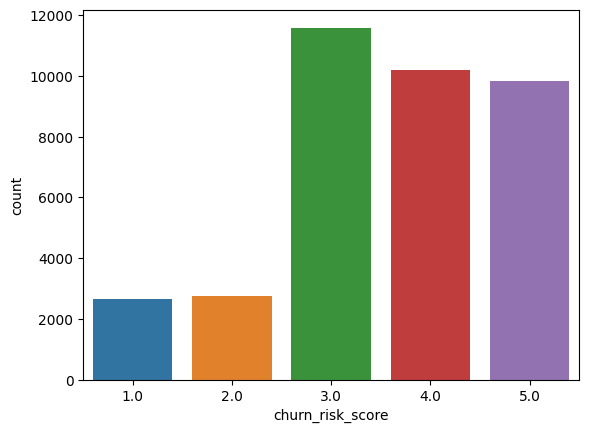

In [ ]:
sns.countplot(data = preprocessed_data, x = 'churn_risk_score')

Dựa vào biểu đồ countplot trên cột `churn_risk_score`, ta thấy được đây là một tập dữ liệu bị mất cân bằng giữa các lớp, các class 3, 4 và 5 có số lượng mẫu nhiều hơn 2 class còn lại rất nhiều, khoảng hơn gấp 3 lần.

<Axes: xlabel='churn_risk_score', ylabel='count'>

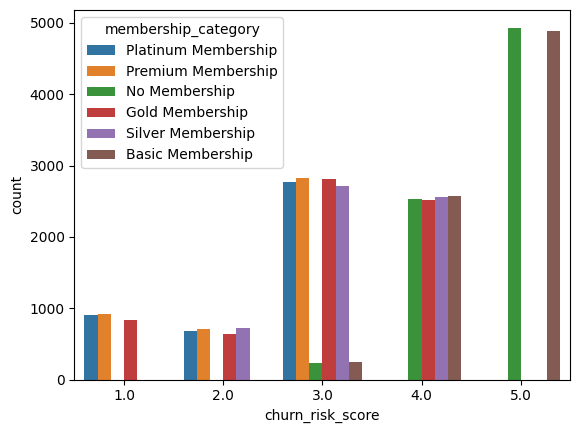

In [ ]:
sns.countplot(data = preprocessed_data, x = 'churn_risk_score', hue = 'membership_category')

Ta nhận thấy 2 nhóm khác hàng là nhóm khách hàng tự do (No Membership) và nhóm khách hàng thông thường (Basic Membership) chính là 2 nhóm khách hàng có nguy cơ rời bỏ dịch vụ cao nhất (mức 5), đây là điều dễ hiểu vì 2 nhóm khách hàng thường không có nhiều ưu đãi hoặc nhu cầu sử dụng dịch vụ không cao.

<Axes: xlabel='region_category', ylabel='count'>

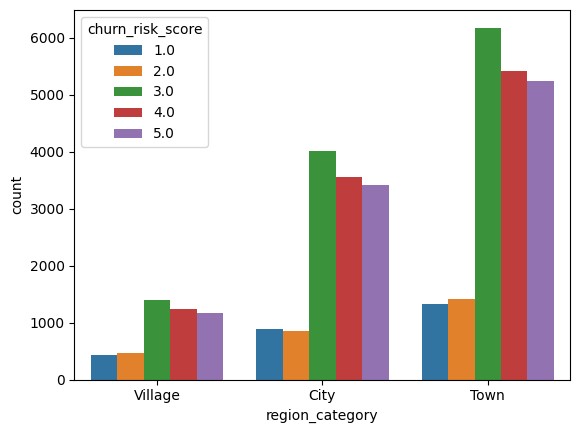

In [ ]:
sns.countplot(data = preprocessed_data, x = 'region_category', hue = 'churn_risk_score')

<Axes: xlabel='churn_risk_score', ylabel='points_in_wallet'>

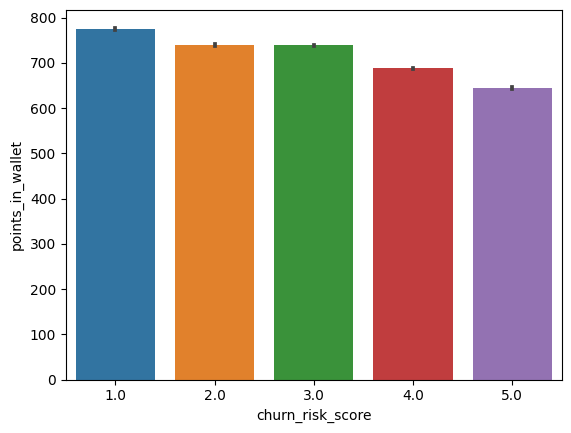

In [ ]:
sns.barplot(x='churn_risk_score', y='points_in_wallet', data=preprocessed_data)

Ta thấy nhóm khách hàng có trung bình `points_in_wallet` cao sẽ có mức độ rời bỏ dịch vụ thấp hơn những khách hàng có `points_in_wallet` thấp hơn.

## Feature Engineering

- Từ cột joining_date ta sẽ tách thành 3 feature khác:
joining_weekday: Thể hiện ngày thứ mấy trong tuần, từ thứ 2 đến chủ nhật, tương ứng từ 0 đến 6.
  - joining_week: Thể hiện tuần thứ mấy trong năm, từ 1 đến 53.
  - joining_month: Thể hiện tháng trong năm, từ 1 đến 12.
-Từ cột last_visit_time ta chỉ tách thành feature là last_visit_hour thể hiện giờ đăng nhập cuối cùng của khách hàng (từ 0 đến 23), còn thông tin về phút và giây sẽ được bỏ đi.

- Lấy get_dummies() trên các cột categorical.

In [ ]:
def feature_engineering(dataframe):
    engineered_df = dataframe.copy()
    # Thêm cột joining_weekday từ cột joining_date
    engineered_df['joining_weekday'] = engineered_df['joining_date'].dt.weekday
    # Thêm cột joining_week từ cột joining_date
    engineered_df['joining_week'] = engineered_df['joining_date'].dt.isocalendar().week
    # Thêm cột joining_week từ cột joining_date
    engineered_df['joining_month'] = engineered_df['joining_date'].dt.month
    engineered_df.drop('joining_date', axis='columns', inplace=True)

    # Thêm cột 'last_visit_hour' từ cột 'last_visit_time'
    engineered_df['last_visit_hour'] = engineered_df['last_visit_time'].apply(lambda x : x.hour)
    engineered_df.drop('last_visit_time', axis='columns', inplace=True)


    categorical_cols = [feature for feature in engineered_df.columns if engineered_df[feature].dtype == "O"] # Lấy tên các cột categorical
    numerical_cols = [feature for feature in engineered_df.columns if engineered_df[feature].dtype != "O"] # Lấy tên các cột numerical

    categorical_data = pd.get_dummies(engineered_df[categorical_cols]) # Lấy get_dummies() các cột categorical
    numerical_data = engineered_df[numerical_cols]

    engineered_df = pd.concat([categorical_data, numerical_data], axis=1)


    return engineered_df

In [ ]:
engineered_data = feature_engineering(preprocessed_data)
engineered_data.head()

,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,membership_category_Basic Membership,membership_category_Gold Membership,membership_category_No Membership,membership_category_Platinum Membership,membership_category_Premium Membership,...,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,joining_weekday,joining_week,joining_month,last_visit_hour
0,1,0,0,0,1,0,0,0,1,0,...,17.0,300.63,53005.25,17.0,781.750000,2.0,3,33,8,16
1,1,0,1,0,0,0,0,0,0,1,...,16.0,306.34,12838.38,10.0,771.481333,1.0,0,35,8,12
2,1,0,0,1,0,0,0,1,0,0,...,14.0,516.16,21027.00,22.0,500.690000,5.0,4,45,11,22
3,0,1,1,0,0,0,0,1,0,0,...,11.0,53.27,25239.56,6.0,567.660000,5.0,5,43,10,15
4,1,0,1,0,0,0,0,1,0,0,...,20.0,113.13,24483.66,16.0,663.060000,5.0,1,37,9,15


In [ ]:
engineered_data.shape

(36992, 53)

## Prepare X, y

Tách tập dữ liệu ra 2 phần là các feature X và label y:

In [ ]:
def prepare_X_y(df):
    feature_names = df.columns.tolist()
    feature_names.remove("churn_risk_score")

    X = df[feature_names]
    y = df.churn_risk_score
    return X, y

In [ ]:
X, y = prepare_X_y(engineered_data)

In [ ]:
X.shape

(36992, 52)

## Train-test split

Chia tập dữ liệu thành 2 tập training và testing:

In [ ]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.7

trainX, testX ,trainY, testY = train_test_split(X.values, y.values, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [ ]:
trainX.shape

(25894, 52)

In [ ]:
testX.shape

(11098, 52)

## Build Model

Tiếp theo ta sẽ sử dụng SVM từ thư viện scikit-learn để xây dựng mô hình phân lớp các khách hành theo điểm số `churn_risk_score`. Ở đây chúng ta sẽ sử dụng biến thể SVC(), được sử dụng trong các bài toán phân lớp.

### Mô hình phân loại SVC với các tham số mặc định.

Đầu tiên, chúng ta sẽ giữ nguyên tập dữ liệu gốc và xây dựng một mô hình SVC với các tham số mặc định từ scikit-learn để xem hiệu quả của mô hình:

In [ ]:
svc_model = SVC(random_state = 42)
svc_model.fit(trainX, trainY)

SVC(random_state=42)

Xem hiệu suất của model trên tập test và tập training và tập testing:

In [ ]:
predicted_label_test = svc_model.predict(testX)
predicted_label_train = svc_model.predict(trainX)

print(classification_report(trainY, predicted_label_train))
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

         1.0       0.49      0.11      0.18      1885
         2.0       0.49      0.15      0.23      1905
         3.0       0.33      1.00      0.49      8132
         4.0       0.00      0.00      0.00      7131
         5.0       0.00      0.00      0.00      6841

    accuracy                           0.33     25894
   macro avg       0.26      0.25      0.18     25894
weighted avg       0.17      0.33      0.18     25894

              precision    recall  f1-score   support

         1.0       0.47      0.11      0.18       767
         2.0       0.48      0.13      0.21       836
         3.0       0.32      1.00      0.49      3455
         4.0       0.00      0.00      0.00      3054
         5.0       0.00      0.00      0.00      2986

    accuracy                           0.33     11098
   macro avg       0.25      0.25      0.17     11098
weighted avg       0.17      0.33      0.18     11098



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Nhận xét:
- Mô hình phân lớp SVM với các tham số mặc định từ scikit-learn được training với tập dữ liệu chưa được áp dụng các kỹ thuật xử lý khác cho ra kết quả vô cùng tệ: Mô hình không thể bắt được và phân loại các trường hợp rơi vào class 4 và 5 ở trên cả tập training và tập testing, điểm số accuracy cũng rất thấp chỉ với 0.33 trên mỗi tập dữ liệu.

Như vậy, ta cần phải áp dụng các kỹ thuật xử lý khác cũng như tinh chỉnh bộ tham số cho mô hình SVC trước khi huấn luyện.

## StandardScaler

Trước tiên, ta hãy áp dụng StandardScaler cho bộ dữ liệu:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(trainX)
X_test_scaled = scaler.transform(testX)

Xây dựng lại mô hình SVC để xem sự thay đổi trong hiệu suất:

In [ ]:
svc_model = SVC(random_state = 42)
svc_model.fit(X_train_scaled, trainY)

predicted_label_test = svc_model.predict(X_test_scaled)
predicted_label_train = svc_model.predict(X_train_scaled)

print(classification_report(trainY, predicted_label_train))
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

         1.0       0.81      0.91      0.86      1885
         2.0       0.89      0.83      0.86      1905
         3.0       0.89      0.91      0.90      8132
         4.0       0.90      0.44      0.59      7131
         5.0       0.67      1.00      0.80      6841

    accuracy                           0.80     25894
   macro avg       0.83      0.82      0.80     25894
weighted avg       0.83      0.80      0.78     25894

              precision    recall  f1-score   support

         1.0       0.60      0.75      0.67       767
         2.0       0.70      0.59      0.64       836
         3.0       0.85      0.86      0.86      3455
         4.0       0.73      0.34      0.46      3054
         5.0       0.64      0.97      0.77      2986

    accuracy                           0.72     11098
   macro avg       0.71      0.70      0.68     11098
weighted avg       0.73      0.72      0.70     11098



Ta đã thấy có sự thay đổi kết quả rõ rệt trên cả tập training và tập testing chỉ với 1 bước là áp dụng StandardScaler. Chỉ số accuracy trên cả hai tập đều tăng hơn gấp 2 lần so với mô hình trước đó. Nhưng chỉ số F1 macro trên tập testing đang có vẻ hơi thấp là 0.68.

### Sử dụng phương pháp Up-sampling

Trong machine learning, up-sampling được sử dụng để giải quyết vấn đề mất cân bằng dữ liệu. Mất cân bằng dữ liệu xảy ra khi số lượng mẫu của một lớp dữ liệu là rất ít so với số lượng mẫu của các lớp khác. Điều này có thể dẫn đến các mô hình học máy không hiệu quả và không chính xác khi phân loại các mẫu, mô hình sẽ luôn phân loại các mẫu vào lớp đa số và thường bỏ qua các lớp hiếm.

Theo như phân tích ở phần  trước đó, ta thấy tập dữ liệu này đang có hiện tượng imbalance giữa các lớp (class 1 và class 2 ít hơn rất nhiều), vì vậy ta sẽ áp dụng phương pháp up-sampling để lấy mẫu lại nhằm giúp các lớp được cân bằng với nhau. Ở đây ta sẽ sử dụng `SVMSMOTE` từ `imblearn`.

In [ ]:
from imblearn.over_sampling import SVMSMOTE
smote = SVMSMOTE(random_state = 42)
X_train_oversampling, y_train_oversampling = smote.fit_resample(X_train_scaled, trainY)

Ta xem qua các lớp sau khi up-sampling:

In [ ]:
s = y_train_oversampling.copy()
temp = pd.Series(s)
temp.value_counts()

4.0    8132
5.0    8132
3.0    8132
2.0    8132
1.0    8132
dtype: int64

Các lớp đã được cân bằng với nhau, ta tiến hành xây dựng lại mô hình phân lớp SVC:

In [ ]:
svc_model = SVC(random_state = 42)
svc_model.fit(X_train_oversampling, y_train_oversampling)

predicted_label_test = svc_model.predict(X_test_scaled)
predicted_label_train = svc_model.predict(X_train_scaled)

print(classification_report(trainY, predicted_label_train))
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

         1.0       0.85      0.94      0.89      1885
         2.0       0.92      0.87      0.89      1905
         3.0       0.89      0.89      0.89      8132
         4.0       0.86      0.40      0.54      7131
         5.0       0.65      1.00      0.78      6841

    accuracy                           0.79     25894
   macro avg       0.83      0.82      0.80     25894
weighted avg       0.82      0.79      0.77     25894

              precision    recall  f1-score   support

         1.0       0.61      0.71      0.66       767
         2.0       0.68      0.62      0.65       836
         3.0       0.87      0.84      0.85      3455
         4.0       0.73      0.35      0.47      3054
         5.0       0.64      0.99      0.78      2986

    accuracy                           0.72     11098
   macro avg       0.71      0.70      0.68     11098
weighted avg       0.74      0.72      0.70     11098



Sau khi up-sampling thì hiệu suất trên tập training đã được tăng lên đôi chút: Cả Accuracy, F1 macro và F1 weighted đều tăng lên 1%

Tuy các chỉ số metric trên tập testing không có gì thay đổi so với mô hình trước đó, nhưng khi ta nhìn vào class 4, ta thấy được Recall trên class này đã tăng lên được một chút sau khi up-sampling (từ 0.32 lên 0.35).

### Sử dụng phương pháp Down-sampling

Với up-sampling thì thời gian training model trở nên lâu hơn, vì thế ta sẽ thử phương pháp down-sampling trên tập dữ liệu training. Ở đây, ta sẽ sử dụng AllKNN từ imblearn.

Tham khảo thêm tại: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.AllKNN.html#

In [ ]:
from imblearn.under_sampling import AllKNN
np.random.seed(42)
down_sample = AllKNN(n_neighbors=10)
X_train_undersampling, y_train_undersampling = down_sample.fit_resample(X_train_scaled, trainY)

In [ ]:
s = y_train_undersampling.copy()
temp = pd.Series(s)
temp.value_counts()

3.0    5597
5.0    4208
4.0    3053
1.0    1885
2.0    1071
dtype: int64

In [ ]:
svc_model = SVC(random_state = 42)
svc_model.fit(X_train_undersampling, y_train_undersampling)

predicted_label_test = svc_model.predict(X_test_scaled)
predicted_label_train = svc_model.predict(X_train_scaled)

print(classification_report(trainY, predicted_label_train))
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

         1.0       0.58      1.00      0.73      1885
         2.0       0.99      0.33      0.50      1905
         3.0       0.87      0.89      0.88      8132
         4.0       0.84      0.36      0.50      7131
         5.0       0.64      1.00      0.78      6841

    accuracy                           0.74     25894
   macro avg       0.78      0.72      0.68     25894
weighted avg       0.79      0.74      0.71     25894

              precision    recall  f1-score   support

         1.0       0.54      0.99      0.70       767
         2.0       0.95      0.27      0.42       836
         3.0       0.85      0.85      0.85      3455
         4.0       0.74      0.32      0.44      3054
         5.0       0.64      1.00      0.78      2986

    accuracy                           0.71     11098
   macro avg       0.74      0.68      0.64     11098
weighted avg       0.75      0.71      0.67     11098



Sau khi sử dụng phương pháp down-sampling thì hiệu suất của mô hình phân loại đã giảm đi rõ rệt trên cả tập dữ liệu training và testing, nhưng thời gian training mô hình đã giảm đi rất nhiều.

### Nhận xét về up-sampling và down-sampling và mô hình chỉ scaled bình thường.

Nhận xét về Up-sampling và Down-sampling:
- Về up-sampling: Khi áp dụng Up-sampling và training mô hình thì số lượng mẫu tăng lên đồng thời với thời gian training cũng tăng lên, thực tế là tổng thời gian vừa up-sampling, tranining mô hình và predict là 5 phút. Điều này sẽ gây khó khăn khi ta áp dụng các kỹ thuật tạo lưới tham số và tìm kiếm như GridSearchCV vì sẽ mất rất nhiều thời gian (Nhóm đã thử GridSearchCV và tổng thời gian là hơn 4 tiếng nhưng kết quả cho ra cũng không khả quan hơn nhiều). Tuy vậy, up-samling đã giúp tăng Recall trên class 4 trên tập testing, tuy nhiên không nhiều.
- Về down-samping: Đây là một thử nghiệm khác và cũng cho ra kết quả không có cải thiện gì hơn (kết quả thấp hơn hơn khi so với up-sampling và khi dùng dữ liệu chỉ được scaled). Nhưng nó được lợi về thời gian training rất nhiều khi thời gian training và predict chỉ là 37s. Nếu phương pháp này cho ra hiệu suất khả quan hơn thì ta sẽ xem xét đến nó để tiết kiệm thời gian, nhưng rất tiếc là nó đều tệ hơn 2 mô hình còn lại trên cả tập traning và testing.

**Hai model ta có được từ 2 phương pháp trên khi đem so với model mà ta traning với dữ liệu chỉ áp dụng StandardScaler đơn thuần thì hiệu suất không được tốt bằng (nếu ta xét thêm yếu tố thời gian training). Mô hình với StandardScaler này cũng có thời gian traning thấp hơn rất nhiều so với up-samling và cũng không quá cao khi so với down-sampling (thời gian training là gần 2 phút)**

**Dựa trên những nhận xét này, ta quyết định sẽ sử dụng tập dữ liệu chỉ được xử lý bằng StandardScaler để xây dựng các model sau này, đây là lựa chọn lý tưởng cho ta khi vừa tiết kiệm được thời gian và cải thiện được hiệu suất mô hình.**

### Dùng GridSearchCV để tăng hiệu suất mô hình.

Tiếp theo ta sẽ sử dụng GridSearchCV để tìm ra bộ tham số tốt nhất nhằm đạt được kết quả phân loại tốt nhất trên tập testing. Ở đây ta chỉ sử dụng một bộ tham số với các tham số:
- `kernel : ['poly, 'rbf', 'sigmoid']`
- `C : [0.1, 1, 10, 20]`
- `gamma: [0.1, 0.01, 0.001]`

Trong đó:
- Tham số kernel: Đây là các hàm kernel sẽ được sử dụng trong thuật toán SVM. Kernel trick trong SVM có chức năng chuyển đổi không gian dữ liệu đầu vào sang một không gian mới, trong đó việc phân chia tuyến tính có thể thực hiện dễ dàng hơn.
- Tham số C là tham số dùng để điều hòa giữa 'hard-margin' và 'soft-margin', điều này có nghĩa là khi tham số C càng lớn, mô hình sẽ cố gắng phân loại chính xác nhiều điểm dữ liệu trong tập training hơn. Ngược lại, khi tham số C càng nhỏ thì mô hình sẽ chấp nhập có nhiều điểm dữ liệu huấn luyện bị phân loại sai để đổi lấy một đường phân chia có lề (margin) lớn hơn.
- Tham số gamma: Đây là hệ số cho các hàm kernel 'rbf', 'poly' và 'sigmoid'. Tham số gamma điều chỉnh mức độ ảnh hưởng của mỗi điểm dữ liệu huấn luyện đến đường biên quyết dịnh. Giá trị gamma nhỏ sẽ tạo ra một đường biên mềm hơn, trong khi giá trị gamma lớn sẽ tạo ra một đường biên cứng hơn.

Bằng thử nghiệm thực tế, khi ta sử dụng hàm `kernel = 'linear'` kết hợp với các tham số khác thì thời gian traning rất là lâu (có thể tính bằng giờ), vì vậy để tiết kiệm thời gian ở bước này, ta chỉ sử dụng GridSearchCV với 3 loại hàm kernel như trên và sẽ sử dụng kernel = 'linear' ở phần phía sau.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('classification', SVC()),
])

parameters = {
    'classification__kernel': ['poly', 'rbf', 'sigmoid'],
    'classification__C': [0.1, 1, 10, 20],
    'classification__gamma': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, cv=3, verbose=1) # Sử dụng F1 macro là tiêu chuẩn đánh giá chính
grid_search.fit(trainX, trainY)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)


best_params = grid_search.best_params_
pipeline.set_params(**best_params)
pipeline.fit(trainX, trainY)

predicted_label_test = pipeline.predict(testX)
predicted_label_train = pipeline.predict(trainX)

print(classification_report(trainY, predicted_label_train))
print(classification_report(testY, predicted_label_test))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameter (CV score=0.700):
{'classification__C': 20, 'classification__gamma': 0.001, 'classification__kernel': 'rbf'}
              precision    recall  f1-score   support

         1.0       0.69      0.85      0.76      1885
         2.0       0.79      0.65      0.72      1905
         3.0       0.86      0.90      0.88      8132
         4.0       0.87      0.33      0.48      7131
         5.0       0.64      1.00      0.78      6841

    accuracy                           0.75     25894
   macro avg       0.77      0.75      0.72     25894
weighted avg       0.79      0.75      0.72     25894

              precision    recall  f1-score   support

         1.0       0.63      0.80      0.70       767
         2.0       0.75      0.61      0.67       836
         3.0       0.85      0.89      0.87      3455
         4.0       0.84      0.32      0.46      3054
         5.0       0.64      1.00      0.78      2986


### Thử với hàm kernel linear

Ta thử xây dựng mô hình với `kernel = 'linear'`, `C = 1`.

In [ ]:
svc_model = SVC(kernel = 'linear', C = 1, random_state = 42)
svc_model.fit(X_train_scaled, trainY)

predicted_label_test = svc_model.predict(X_test_scaled)
predicted_label_train = svc_model.predict(X_train_scaled)
print(classification_report(trainY, predicted_label_train))
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

         1.0       0.67      0.83      0.75      1885
         2.0       0.77      0.64      0.70      1905
         3.0       0.85      0.91      0.88      8132
         4.0       0.88      0.32      0.47      7131
         5.0       0.64      1.00      0.78      6841

    accuracy                           0.75     25894
   macro avg       0.76      0.74      0.72     25894
weighted avg       0.78      0.75      0.72     25894

              precision    recall  f1-score   support

         1.0       0.64      0.80      0.71       767
         2.0       0.76      0.63      0.68       836
         3.0       0.85      0.90      0.88      3455
         4.0       0.87      0.32      0.46      3054
         5.0       0.64      1.00      0.78      2986

    accuracy                           0.74     11098
   macro avg       0.75      0.73      0.70     11098
weighted avg       0.78      0.74      0.71     11098



Ta thay đổi tham số `C = 5`

In [ ]:
svc_model = SVC(kernel = 'linear', C = 5, random_state = 42)
svc_model.fit(X_train_scaled, trainY)

predicted_label_test = svc_model.predict(X_test_scaled)
predicted_label_train = svc_model.predict(X_train_scaled)
print(classification_report(trainY, predicted_label_train))
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

         1.0       0.67      0.83      0.75      1885
         2.0       0.78      0.64      0.70      1905
         3.0       0.85      0.91      0.88      8132
         4.0       0.88      0.32      0.47      7131
         5.0       0.64      1.00      0.78      6841

    accuracy                           0.75     25894
   macro avg       0.76      0.74      0.72     25894
weighted avg       0.78      0.75      0.72     25894

              precision    recall  f1-score   support

         1.0       0.64      0.80      0.71       767
         2.0       0.76      0.63      0.69       836
         3.0       0.85      0.90      0.88      3455
         4.0       0.87      0.32      0.46      3054
         5.0       0.64      1.00      0.78      2986

    accuracy                           0.74     11098
   macro avg       0.75      0.73      0.70     11098
weighted avg       0.78      0.74      0.71     11098



Nhận xét:
- Khi sử dụng hàm kernel là linear với các tham số của mô hình chưa được điều chỉnh gì thì kết quả cũng cho ra tương tự như khi ta sử dụng GridSearchCV trên 3 hàm kernel còn lại.
- Nhưng thời gian training của linear kernel lâu hơn các hàm kernel khác rất nhiều, khi ta tăng tham số C từ 1 lên 5 thì thời gian training cũng tăng lên gấp 4 lần (gần 5 phút), và càng điều chỉnh thêm nhiều các parameters khác thì thời gian này càng lâu (điều này đã gặp phải trong quá trình làm bài).

=> Không có sự khác biệt giữa kết quả của phần GridSearchCV phía trước và phần linear kernel, ta sẽ chọn kết quả là model do GridSearchCV trả về là mô hình SVM cuối cùng xây dựng được bởi vì chúng đều có hiệu suất tương tự, có thể sẽ
tiết kiệm được thời gian nếu nhưng chúng ta muốn thay đổi hoặc tăng thêm số lượng hyperparameters sau này (điều này sẽ bất lợi nếu sử dụng hàm kernel là linear).


### Build Final Model

In [ ]:
def calculate_performance(y_true, y_pred):

    print("precision", precision_score(y_true , y_pred, average = 'macro'))
    print("recall",recall_score(y_true , y_pred, average = 'macro'))
    print("accuracy", accuracy_score(y_true, y_pred))
    print("F1", f1_score(y_true , y_pred, average = 'macro'))

    main_score = f1_score(y_true , y_pred, average= 'macro') # Sử dụng F1 macro là tiêu chuẩn đánh giá chính.
    return main_score

In [ ]:
def build_model(X, y):
    pipe = Pipeline(steps=[('scaled', StandardScaler()), ('classifier', SVC(C = 20, gamma = 0.001, kernel = 'rbf', random_state = 42))])
    model = pipe.fit(X, y)
    return model

model = build_model(trainX, trainY)

train_pred = model.predict(trainX)
print("Training Main score (F1-macro):", calculate_performance(trainY, train_pred))
print()
test_pred = model.predict(testX)
print("Testing Main score (F1-macro):", calculate_performance(testY, test_pred))


predicted_label_train = model.predict(trainX)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = model.predict(testX)
print(classification_report(testY, predicted_label_test))

precision 0.7703537089512337
recall 0.7478754659791085
accuracy 0.7496331196416158
F1 0.7239492805012182
Training Main score (F1-macro): 0.7239492805012182

precision 0.7429318267839555
recall 0.7237028559889768
accuracy 0.7351775094611642
F1 0.6974183982513285
Testing Main score (F1-macro): 0.6974183982513285
              precision    recall  f1-score   support

         1.0       0.69      0.85      0.76      1885
         2.0       0.79      0.65      0.72      1905
         3.0       0.86      0.90      0.88      8132
         4.0       0.87      0.33      0.48      7131
         5.0       0.64      1.00      0.78      6841

    accuracy                           0.75     25894
   macro avg       0.77      0.75      0.72     25894
weighted avg       0.79      0.75      0.72     25894


              precision    recall  f1-score   support

         1.0       0.63      0.80      0.70       767
         2.0       0.75      0.61      0.67       836
         3.0       0.85      0.89  

<Figure size 600x600 with 0 Axes>

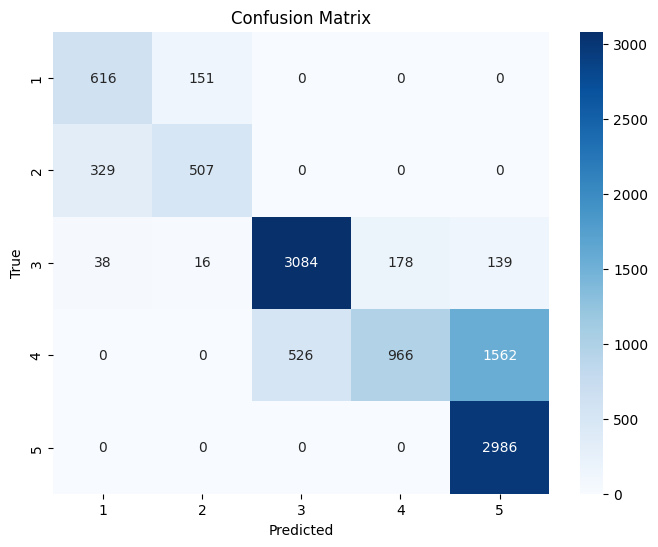

In [ ]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(6, 6))
labels = ['1', '2', '3', '4', '5']
cm = confusion_matrix(y_true=testY, y_pred=predicted_label_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Nhận xét mô hình thông qua Confusion Matrix:
- Class 1: Mô hình phân loại được chính xác 616 trường hợp thuộc về lớp 1 và phân loại nhầm 151 vào class 2.
- Class 2: Mô hình phân loại chính xác 507 trường hợp thuộc lớp 2 và phân loại nhầm 329 trường hợp vào class 1.
- Class 3: Đây là class mô hình phân loại được tốt nhất khi đã phân loại chính xác 3084 mẫu thuộc về class 3 trên tổng số 3455 trường hợp.
- Class 4: Class này mô hình phân loại tệ nhất khi đã phân loại nhầm 1562 mẫu vào class 5 và chỉ chính xác được 966 trường hợp, bên cạnh đó mô hình cũng đã phân loại nhầm 526 trường hợp vào class 3. Đây chính là lý do mà Recall của class 4 chỉ là 0.32
- Class 5: Mô hình đã bắt được và phân loại chính xác hết tất cả các trường hợp thuộc class 5, nhưng do cũng phân loại nhầm các class khác vào class 5 nên Precision chỉ là 0.64

Như vậy ta thấy được mô hình có xu hướng nhẫm lẫn class 1 và class 2 với nhau và nhầm lẫn class 4 với class 3 và class 5.

 Với bài toán này, ta sẽ lựa chọn F1-score làm main score để đánh giá mô hình phân loại mà ta xây dựng được.
 - Khi xây dựng một model phân loại mức độ rời bỏ dịch vụ của khách hàng, thì recall rất quan trọng trong việc bao phủ hết tất các trường hợp khách hàng trong từng lớp, giúp cho công ty có thể đưa ra những quyết định kịp thời giúp níu chân khách hàng mà không bị bỏ lỡ một trường hợp nào.
 - Bên cạnh đó, việc phân loại đúng một khách hàng nào đó có thật sự có ý muốn rời đi hay không cũng rất quan trọng, điều này giúp công ty có những giải pháp cụ thể hơn cho từng loại đối tượng, giảm thiểu chi phí và đạt được hiệu quả cao nhất trong kinh doanh.


 Vì vậy, trong trường hợp ta muốn đánh giá model thông qua cả 2 tiêu chí trên thì F1-score chính là lựa chọn hợp lý nhất.

 Ở đây chúng ta sẽ sử dụng F1 macro, đây là một phép đo đánh giá hiệu suất dùng để đo lường độ chính xác của mô hình phân loại đa lớp và nó được tính bằng cách tính trung bình điều hòa của các giá trị F1 score cho từng lớp riêng biệt, nó hữu ích khi chúng ta muốn đảm bảo rằng mô hình hoạt động tốt trên tất cả các lớp, không chỉ tập trung quá mức vào các lớp đa số.

## So sánh với một số mô hình phân loại khác.

Ta thực hiện so sánh với các mô hình phân lớp khác đã được học trong chương trình

### Logistic Regression

Đầu tiên ta sẽ thử xây dựng mô hình phân loại sử dụng hồi quy logistic trên tập dữ liệu này:

In [ ]:
from sklearn.linear_model import LogisticRegression

def build_model(X, y):
    pipe = Pipeline(steps=[('scaled', StandardScaler()), ('classifier', LogisticRegression(C = 0.1, max_iter = 1000, solver = 'saga', penalty = 'l1', random_state = 42))])
    model = pipe.fit(X, y)
    return model

model = build_model(trainX, trainY)

train_pred = model.predict(trainX)
print("Training Main score (F1-macro):", calculate_performance(trainY, train_pred))
print()
test_pred = model.predict(testX)
print("Testing Main score (F1-macro):", calculate_performance(testY, test_pred))


predicted_label_train = model.predict(trainX)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = model.predict(testX)
print(classification_report(testY, predicted_label_test))

precision 0.7399239378503452
recall 0.7185992190542362
accuracy 0.7320614814242682
F1 0.6937375473919134
Training Main score (F1-macro): 0.6937375473919134

precision 0.7317679122819992
recall 0.7139507009764491
accuracy 0.7267976211930077
F1 0.6869675507332681
Testing Main score (F1-macro): 0.6869675507332681
              precision    recall  f1-score   support

         1.0       0.62      0.90      0.73      1885
         2.0       0.81      0.49      0.61      1905
         3.0       0.86      0.89      0.88      8132
         4.0       0.77      0.35      0.49      7131
         5.0       0.64      0.96      0.77      6841

    accuracy                           0.73     25894
   macro avg       0.74      0.72      0.69     25894
weighted avg       0.76      0.73      0.71     25894


              precision    recall  f1-score   support

         1.0       0.59      0.89      0.71       767
         2.0       0.81      0.49      0.61       836
         3.0       0.86      0.88  

Bộ phân loại sử dụng hồi quy Logistic cho ra kết quả tương đối xấp xỉ với mô hình SVM phía trên, nhưng có thời gian training nhanh hơn mô hình SVM, chỉ với 42s thay vì 3 phút như SVM.

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

def build_model(X, y):
    pipe = Pipeline(steps=[('scaled', StandardScaler()), ('classifier', GaussianNB())])
    model = pipe.fit(X, y)
    return model


model = build_model(trainX, trainY)

train_pred = model.predict(trainX)
print("Training performance:", calculate_performance(trainY, train_pred))
print()
test_pred = model.predict(testX)
print("Testing performance:", calculate_performance(testY, test_pred))


predicted_label_train = model.predict(trainX)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = model.predict(testX)
print(classification_report(testY, predicted_label_test))

precision 0.7326755013265667
recall 0.6484274221322559
accuracy 0.6445508612033676
F1 0.609623004797412
Training performance: 0.609623004797412

precision 0.723687297305465
recall 0.6424225391470235
accuracy 0.636330870427104
F1 0.6000531725834859
Testing performance: 0.6000531725834859
              precision    recall  f1-score   support

         1.0       0.56      1.00      0.72      1885
         2.0       0.98      0.26      0.41      1905
         3.0       1.00      0.48      0.65      8132
         4.0       0.48      0.50      0.49      7131
         5.0       0.64      1.00      0.78      6841

    accuracy                           0.64     25894
   macro avg       0.73      0.65      0.61     25894
weighted avg       0.73      0.64      0.63     25894


              precision    recall  f1-score   support

         1.0       0.54      1.00      0.70       767
         2.0       0.97      0.26      0.41       836
         3.0       1.00      0.46      0.63      3455
     

Mô hình phân loại sử dụng GaussianNB() cho ra kết quả không tốt so với các mô hình còn lại.

### Decision Tree

In [ ]:
def build_model(X, y):

    pipe = Pipeline(steps=[('scaled', StandardScaler()), ('classifier', DecisionTreeClassifier(min_samples_split = 7, min_samples_leaf = 3, max_depth = 10, criterion = 'entropy',
                                                      ccp_alpha = 0.0001, random_state = 42))])
    model = pipe.fit(X, y)
    return model

model = build_model(trainX, trainY)

train_pred = model.predict(trainX)
print("Training Main score (F1-macro):", calculate_performance(trainY, train_pred))
print()
test_pred = model.predict(testX)
print("Testing Main score (F1-macro):", calculate_performance(testY, test_pred))


predicted_label_train = model.predict(trainX)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = model.predict(testX)
print(classification_report(testY, predicted_label_test))

precision 0.7879211769690614
recall 0.7823703601802388
accuracy 0.7861280605545686
F1 0.7697793813278816
Training Main score (F1-macro): 0.7697793813278816

precision 0.7473910697489601
recall 0.7467207791667047
accuracy 0.757613984501712
F1 0.7334517295411611
Testing Main score (F1-macro): 0.7334517295411611
              precision    recall  f1-score   support

         1.0       0.73      0.85      0.79      1885
         2.0       0.81      0.72      0.76      1905
         3.0       0.85      0.94      0.89      8132
         4.0       0.85      0.48      0.61      7131
         5.0       0.71      0.93      0.80      6841

    accuracy                           0.79     25894
   macro avg       0.79      0.78      0.77     25894
weighted avg       0.80      0.79      0.77     25894


              precision    recall  f1-score   support

         1.0       0.67      0.77      0.72       767
         2.0       0.76      0.69      0.73       836
         3.0       0.84      0.93   

Decision Tree với các kỹ thuật cắt tỉa cây (Pre-pruning) đã cho ra kết quả phân loại khá tốt, là mô hình tốt nhất mà nhóm có thể build được tính đến hiện tại. Mô hình Decision Tree này đã được áp dụng kỹ thuật Pre-pruning để giảm thiểu bớt hiện tượng overfitting và có thời gian training là 1.076s.

## Tổng kết.

- Bài thực hành này được thực hiện dựa trên mục tiêu là xây dựng một mô hình phân loại SVM đạt được hiệu suất tốt nhất trên tập testing. Đây là một tập dữ liệu khó và đòi hỏi cần có nhiều phân tích để đưa ra hướng xử lý, nhất là ở phần data preprocessing và data engineering. Phần lớn hiệu suất của các mô hình phụ thuộc vào các bước này rất nhiều. Ví dụ, ở phần data engineering lúc đầu nhóm đã thử phương pháp chuyển các cột categorical sang numerical bằng cách sử dụng LabelEncoder() để mã hóa mỗi giá trị trong feature thành mỗi con số riêng biệt và xây dựng model, các model này có hiệu suất không được tốt (Accuracy cao nhất trên tập testing đạt được trên các lần thử nghiệm là 0.69, nhóm không đưa vào bài vì sẽ làm rối bài làm). Nhưng khi sử dụng phương pháp get_dummies() trên các cột categorical thì kết quả các model mới cải thiện được như các kết quả ở trên. Vì vậy khi xây dựng một mô hình máy học thì bước xử lý tập data chính là một bước vô cùng quan trọng và cần nhiều thời gian nhất để thử nghiệm.
- Mô hình SVM phía trên chưa phải là mô hình tốt nhất vì hiệu suất phân lớp vẫn còn đang ở mức khá (nhất là trên class 4 đang có recall khá thấp), mô hình này vẫn có thể được cải tiến thêm nhờ áp dụng các kỹ thuật xử lý tốt hơn, hiệu quả hơn ở phần data preprocessing hoặc data enginerring, cũng như nếu có nhiều thời gian hơn để tuning các hyperparameter của mô hình SVM, hoặc tìm được một phương pháp nào đó giúp thời gian training giảm xuống mà vẫn đảm bảo được kết quả.
- Tổng quát lại, chương trình đã hoàn thành một bài toán phân loại bằng thuật toán SVM với hiệu suất tạm chấp nhận được. Chương trình đã trải qua các bước cơ bản của quá trình phân loại dữ liệu từ việc nạp và tiền xử lý dữ liệu, xây dựng mô hình, điều chỉnh tham số và đánh giá hiệu suất. Bên cạng đó, việc so sánh mô hình với các thuật toán khác giúp chúng ta có góc nhìn rõ hơn về hiệu suất của thuật toán SVM so với các phương pháp khác.